In [3]:
import pyspark
from pyspark.sql import functions as F
from pyspark.sql.functions import cast, count, when, col, lit
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import to_timestamp, to_date
from pyspark.sql.functions import size, split

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
spark = SparkSession.builder.getOrCreate()

In [6]:
folder_path = "gs://yelpfrog/landing/yelp_dataset/yelp_academic_dataset_"

# Business

In [7]:
business = spark.read.json(f"{folder_path}business.json")
business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

24/10/25 22:10:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
# # Add new column called zipcode to make it a int 
# business = business.withColumn("zipcode", col("postal_code").cast(IntegerType()))

# Produced missing values 
# Might be due to some being in alphanumeric format

In [9]:
# Names of column
business.columns

['address',
 'attributes',
 'business_id',
 'categories',
 'city',
 'hours',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'postal_code',
 'review_count',
 'stars',
 'state']

In [10]:
# Number of observations
business.count()

150346

In [11]:
# Number of null values within each column
missing_business = business.select(
    [count(F.when(col(c).isNull(), lit(1))).alias(c)
    for c in business.columns])
missing_business.show()

+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|address|attributes|business_id|categories|city|hours|is_open|latitude|longitude|name|postal_code|review_count|stars|state|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|      0|     13744|          0|       103|   0|23223|      0|       0|        0|   0|          0|           0|    0|    0|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+



In [12]:
review_count_stats = business.select([
                        F.mean('review_count').alias("mean"),
                        F.stddev('review_count').alias("std"),
                        F.min('review_count').alias("min"),
                        F.max('review_count').alias("max")
                        ])
review_count_stats.show()

+-----------------+------------------+---+----+
|             mean|               std|min| max|
+-----------------+------------------+---+----+
|44.86656113232144|121.12013570117037|  5|7568|
+-----------------+------------------+---+----+



In [13]:
stars_stats = business.select([
                        F.mean('stars').alias("mean"),
                        F.stddev('stars').alias("std"),
                        F.min('stars').alias("min"),
                        F.max('stars').alias("max")
                        ])
stars_stats.show()

+------------------+------------------+---+---+
|              mean|               std|min|max|
+------------------+------------------+---+---+
|3.5967235576603303|0.9744207509201411|1.0|5.0|
+------------------+------------------+---+---+



In [14]:
address_stats = business.select([
                        F.min('address').alias("min"),
                        F.max('address').alias("max")
                        ])
address_stats.show()

+---+---------------+
|min|            max|
+---+---------------+
|   |​185 E State St|
+---+---------------+



In [15]:
categories_stats = business.select([
                        F.min('categories').alias("min"),
                        F.max('categories').alias("max")
                        ])
categories_stats.show(truncate=False)

+--------------------------------------------------+---------------------------------------------------------------+
|min                                               |max                                                            |
+--------------------------------------------------+---------------------------------------------------------------+
|3D Printing, Local Services, Hobby Shops, Shopping|Zoos, Tours, Arts & Entertainment, Hotels & Travel, Active Life|
+--------------------------------------------------+---------------------------------------------------------------+



In [16]:
city_stats = business.select([
                        F.min('city').alias("min"),
                        F.max('city').alias("max")
                        ])
city_stats.show()

+-----------+-------+
|        min|    max|
+-----------+-------+
|AB Edmonton|​Lithia|
+-----------+-------+



In [17]:
name_stats = business.select([
                        F.min('name').alias("min"),
                        F.max('name').alias("max")
                        ])
name_stats.show(truncate=False)

+-------------+----------------------------------------------------+
|min          |max                                                 |
+-------------+----------------------------------------------------+
| Grow Academy|​​Transformational Abdominal Massage by Jada Delaney|
+-------------+----------------------------------------------------+



In [18]:
state_stats = business.select([
                        F.min('state').alias("min"),
                        F.max('state').alias("max")
                        ])
state_stats.show()

+---+---+
|min|max|
+---+---+
| AB|XMS|
+---+---+



# Graphs

In [19]:
business_df = business.toPandas()

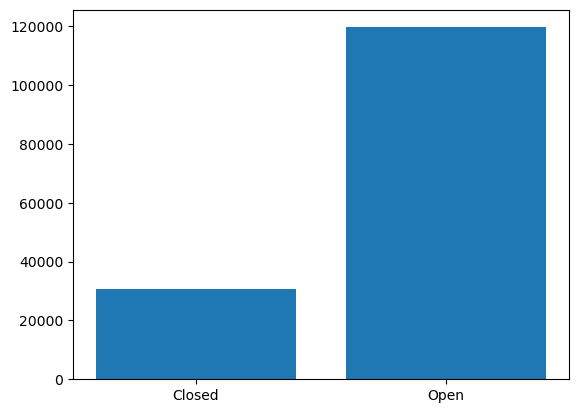

In [24]:
plt.hist(business_df['is_open'], bins=[0, 0.5, 1], rwidth=0.8)
plt.xticks([0.25, 0.75], ['Closed', 'Open'])
plt.show()

(array([  26700.,  101241.,  209098.,  387877.,       0.,  666514.,
        1357223., 2224375., 1504026.,  268454.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

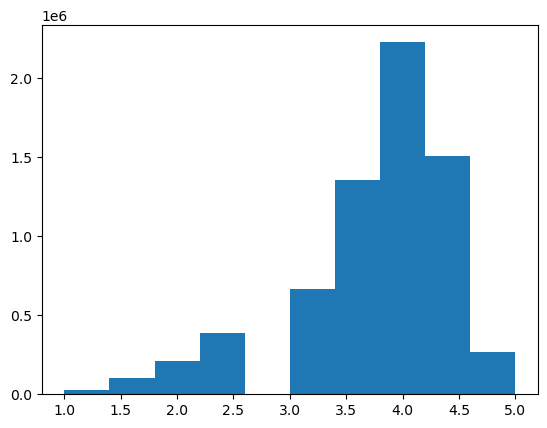

In [33]:
plt.hist(business_df['stars'], weights=business_df['review_count'], bins=10)

# Check In

In [35]:
checkin = spark.read.json(f"{folder_path}checkin.json")
checkin.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)



In [8]:
# Names of column
checkin.columns

['business_id', 'date']

In [10]:
# Number of observations
checkin.count()

131930

In [9]:
# Number of null values within each column
missing_checkin = checkin.select(
    [count(F.when(col(c).isNull(), lit(1))).alias(c)
    for c in checkin.columns])
missing_checkin.show()

+-----------+----+
|business_id|date|
+-----------+----+
|          0|   0|
+-----------+----+



In [36]:
# Create new df with new column called timestamp using date column
# timestamp column for later use 
checkin = checkin.withColumn("timestamp", to_timestamp("date", "yyyy-MM-dd HH:mm:ss"))

In [158]:
checkin_date_stats = checkin.select([
                        F.min('date').alias("min"),
                        F.max('date').alias("max")
                        ])
checkin_date_stats.show()

+--------------------+-------------------+
|                 min|                max|
+--------------------+-------------------+
|2009-12-30 02:53:...|2022-01-19 01:15:21|
+--------------------+-------------------+



# Review

In [24]:
review = spark.read.json(f"{folder_path}review.json")
review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [25]:
# Names of column
review.columns

['business_id',
 'cool',
 'date',
 'funny',
 'review_id',
 'stars',
 'text',
 'useful',
 'user_id']

In [26]:
# Number of observations
review.count()

6990280

In [27]:
# Number of null values within each column
missing_review = review.select(
    [count(F.when(col(c).isNull(), lit(1))).alias(c)
    for c in review.columns])
missing_review.show()

+-----------+----+----+-----+---------+-----+----+------+-------+
|business_id|cool|date|funny|review_id|stars|text|useful|user_id|
+-----------+----+----+-----+---------+-----+----+------+-------+
|          0|   0|   0|    0|        0|    0|   0|     0|      0|
+-----------+----+----+-----+---------+-----+----+------+-------+



In [143]:
# The better star stats
stars_review_stats = review.select([
                        F.mean('stars').alias("mean"),
                        F.stddev('stars').alias("std"),
                        F.min('stars').alias("min"),
                        F.max('stars').alias("max")
                        ])
stars_review_stats.show()

+----------------+------------------+---+---+
|            mean|               std|min|max|
+----------------+------------------+---+---+
|3.74858374771826|1.4787045052556858|1.0|5.0|
+----------------+------------------+---+---+



In [144]:
# Create new df with new column called datetime using date column
# datetime column for later use 
review = review.withColumn("datetime", to_date(col("date"), "yyyy-MM-dd"))

In [44]:
# Add a word_count column
review = review.withColumn("word_count", size(split(col("text"), " ")))

In [159]:
review_date_stats = review.select([
                        F.min('date').alias("min"),
                        F.max('date').alias("max")
                        ])
review_date_stats.show()

+-------------------+-------------------+
|                min|                max|
+-------------------+-------------------+
|2005-02-16 03:23:22|2022-01-19 19:48:45|
+-------------------+-------------------+



In [160]:
review_word_count_stats = review.select([
                        F.count('word_count').alias("count"),
                        F.mean('word_count').alias("mean"),
                        F.min('word_count').alias("min"),
                        F.max('word_count').alias("max")
                        ])
review_word_count_stats.show()

+-------+------------------+---+----+
|  count|              mean|min| max|
+-------+------------------+---+----+
|6990280|105.79662159455701|  1|3079|
+-------+------------------+---+----+



# Tip

In [139]:
tip = spark.read.json(f"{folder_path}tip.json")
tip.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)



In [140]:
# Names of column
tip.columns

['business_id', 'compliment_count', 'date', 'text', 'user_id']

In [141]:
# Number of observations
tip.count()

908915

In [142]:
# Number of null values within each column
missing_tip = tip.select(
    [count(F.when(col(c).isNull(), lit(1))).alias(c)
    for c in tip.columns])
missing_tip.show()

+-----------+----------------+----+----+-------+
|business_id|compliment_count|date|text|user_id|
+-----------+----------------+----+----+-------+
|          0|               0|   0|   0|      0|
+-----------+----------------+----+----+-------+



In [134]:
# Create new df with new column called datetime using date column
# datetime column for later use 
tip = tip.withColumn("datetime", to_date(col("date"), "yyyy-MM-dd"))

In [149]:
# Add a word_count column
tip = tip.withColumn("word_count", size(split(col("text"), " ")))

In [162]:
tip_date_stats = tip.select([
                        F.min('date').alias("min"),
                        F.max('date').alias("max")
                        ])
tip_date_stats.show()

+-------------------+-------------------+
|                min|                max|
+-------------------+-------------------+
|2009-04-16 13:11:49|2022-01-19 20:38:55|
+-------------------+-------------------+



In [161]:
tip_compliment_count_stats = tip.select([
                        F.mean('compliment_count').alias("mean"),
                        F.stddev('compliment_count').alias("std"),
                        F.min('compliment_count').alias("min"),
                        F.max('compliment_count').alias("max")
                        ])
tip_compliment_count_stats.show()

+--------------------+------------------+---+---+
|                mean|               std|min|max|
+--------------------+------------------+---+---+
|0.012524823553357574|0.1207633932798427|  0|  6|
+--------------------+------------------+---+---+



In [163]:
tip_word_count_stats = tip.select([
                        F.count('word_count').alias("count"),
                        F.mean('word_count').alias("mean"),
                        F.min('word_count').alias("min"),
                        F.max('word_count').alias("max")
                        ])
tip_word_count_stats.show()

+------+------------------+---+---+
| count|              mean|min|max|
+------+------------------+---+---+
|908915|11.295122206146889|  1|225|
+------+------------------+---+---+



# User

In [93]:
user = spark.read.json(f"{folder_path}user.json")
user.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [94]:
# Names of column
user.columns

['average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'cool',
 'elite',
 'fans',
 'friends',
 'funny',
 'name',
 'review_count',
 'useful',
 'user_id',
 'yelping_since']

In [95]:
# Number of observations
user.count()

1987897

In [97]:
# Number of null values within each column
missing_user = user.select(
    [count(F.when(col(c).isNull(), lit(1))).alias(c)
    for c in user.columns])
missing_user.show()

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+----+------------+------+-------+-------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|friends|funny|name|review_count|useful|user_id|yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+----+------------+------+-------+-------------+
|            0|              0|              0|               0|             0|              0|              0|              0|                0|               0|       

In [151]:
# Create new df with new column called yelpstart using yelping_since column
# datetime column for later use 
user = user.withColumn("yelpstart", to_date(col("yelping_since"), "yyyy-MM-dd"))

In [107]:
user_number = ['average_stars', 'compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot',
                'compliment_list', 'compliment_more', 'compliment_note', 'compliment_photos',
                'compliment_plain', 'compliment_profile', 'compliment_writer',
                'cool', 'fans', 'friends', 'funny', 'review_count', 'useful']

for col in user_number:
    user_number_stats = user.select([
                            F.mean(col).alias("mean"),
                            F.stddev(col).alias("std"),
                            F.min(col).alias("min"),
                            F.max(col).alias("max")
                            ])
    user_number_stats.show()

+------------------+------------------+---+---+
|              mean|               std|min|max|
+------------------+------------------+---+---+
|3.6304941503508696|1.1833369995975143|1.0|5.0|
+------------------+------------------+---+---+



+------------------+-----------------+---+-----+
|              mean|              std|min|  max|
+------------------+-----------------+---+-----+
|2.8293080577112395|96.66385446471259|  0|49967|
+------------------+-----------------+---+-----+



+-------------------+------------------+---+-----+
|               mean|               std|min|  max|
+-------------------+------------------+---+-----+
|0.13364927860950543|11.356823097797163|  0|13654|
+-------------------+------------------+---+-----+



+------------------+----------------+---+-----+
|              mean|             std|min|  max|
+------------------+----------------+---+-----+
|2.8293080577112395|96.6638544647126|  0|49967|
+------------------+----------------+---+-----+



+------------------+-----------------+---+-----+
|              mean|              std|min|  max|
+------------------+-----------------+---+-----+
|1.8070724992290847|73.60184094967364|  0|25784|
+------------------+-----------------+---+-----+



+-------------------+------------------+---+-----+
|               mean|               std|min|  max|
+-------------------+------------------+---+-----+
|0.06390723463036566|10.043626594119369|  0|12669|
+-------------------+------------------+---+-----+



+-------------------+-----------------+---+-----+
|               mean|              std|min|  max|
+-------------------+-----------------+---+-----+
|0.29226313033321144|12.82466711993018|  0|13501|
+-------------------+-----------------+---+-----+



+------------------+-----------------+---+-----+
|              mean|              std|min|  max|
+------------------+-----------------+---+-----+
|1.4431346292086562|60.16790049259038|  0|59031|
+------------------+-----------------+---+-----+



+-----------------+-----------------+---+-----+
|             mean|              std|min|  max|
+-----------------+-----------------+---+-----+
|1.226859339291724|95.15751297164891|  0|82630|
+-----------------+-----------------+---+-----+



+------------------+------------------+---+------+
|              mean|               std|min|   max|
+------------------+------------------+---+------+
|3.0118411567601338|119.38980389840353|  0|101097|
+------------------+------------------+---+------+



+-------------------+------------------+---+-----+
|               mean|               std|min|  max|
+-------------------+------------------+---+-----+
|0.17931764070271247|15.155253377853501|  0|14180|
+-------------------+------------------+---+-----+



+-----------------+-----------------+---+-----+
|             mean|              std|min|  max|
+-----------------+-----------------+---+-----+
|1.056448095650831|32.17972805346816|  0|15934|
+-----------------+-----------------+---+-----+



+------------------+-----------------+---+------+
|              mean|              std|min|   max|
+------------------+-----------------+---+------+
|23.792913817969442|565.3512954713353|  0|199878|
+------------------+-----------------+---+------+



+------------------+-----------------+---+-----+
|              mean|              std|min|  max|
+------------------+-----------------+---+-----+
|1.4657404282012598|18.13075272385579|  0|12497|
+------------------+-----------------+---+-----+



+----+----+--------------------+--------------------+
|mean| std|                 min|                 max|
+----+----+--------------------+--------------------+
|NULL|NULL|---2PmXbF47D870st...|zzzOOwSYzuTPvsafS...|
+----+----+--------------------+--------------------+



+------------------+-----------------+---+------+
|              mean|              std|min|   max|
+------------------+-----------------+---+------+
|16.970536199813168|407.8034374841018|  0|185823|
+------------------+-----------------+---+------+



+------------------+-----------------+---+-----+
|              mean|              std|min|  max|
+------------------+-----------------+---+-----+
|23.394409267683386|82.56699161797889|  0|17473|
+------------------+-----------------+---+-----+



+-----------------+-----------------+---+------+
|             mean|              std|min|   max|
+-----------------+-----------------+---+------+
|42.29633527290398|641.4805967755902|  0|206296|
+-----------------+-----------------+---+------+



In [166]:
yelping_since_stats = user.select([
                        F.min('yelping_since').alias("min"),
                        F.max('yelping_since').alias("max")
                        ])
yelping_since_stats.show()

+-------------------+-------------------+
|                min|                max|
+-------------------+-------------------+
|2004-10-12 08:46:11|2022-01-19 17:15:47|
+-------------------+-------------------+

